In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/My Drive/Dogs Project')
gdrive_path = os.getcwd()

In [3]:
# update google colab to the latest version of fastai
!pip install -Uqq fastai

     |████████████████████████████████| 194kB 13.4MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 


In [4]:
from datetime import datetime
import numpy as np
import pandas as pd
import tarfile

# according to fastai book, use the star import notation despite python best practices
from fastai.vision.all import *
from fastai.vision.widgets import *

In [5]:
SEED = 42

def set_seed(seed, dls=None, use_cuda=True):
    # For reproducibility. Run before any fits.
    # see 1: https://github.com/fastai/fastai/issues/2832 and
    # and 2: https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/28
    np.random.seed(seed) # cpu vars
    torch.manual_seed(seed) # cpu  vars
    random.seed(seed) # Python

    if dls is not None:  # DataLoaders object
        dls.rng.seed(seed)

    if use_cuda: # GPU
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [6]:
# this function is necessary because the tar file does not have .tgz extension
def extract_tar(fname, destparent):
    tarfile.open(fname).extractall(destparent)

# download and extract Stanford dogs dataset
download_path = untar_data('http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar', extract_func=extract_tar)

In [7]:
# rename folders to be just the dog breed name
# e.g., change "n02109047-Great_Dane" to "Great Dane"

for path in download_path.ls():
    old_folder = os.path.basename(path)
    new_folder = old_folder[10:].replace('_', ' ').title()  # replace underscore with space, then proper case
    path.rename(download_path / new_folder)

download_path.ls()

(#120) [Path('/root/.fastai/data/images/Bedlington Terrier'),Path('/root/.fastai/data/images/Chesapeake Bay Retriever'),Path('/root/.fastai/data/images/Miniature Schnauzer'),Path('/root/.fastai/data/images/Irish Setter'),Path('/root/.fastai/data/images/Weimaraner'),Path('/root/.fastai/data/images/Brabancon Griffon'),Path('/root/.fastai/data/images/Malinois'),Path('/root/.fastai/data/images/Chihuahua'),Path('/root/.fastai/data/images/Boxer'),Path('/root/.fastai/data/images/Rottweiler')...]

In [8]:
# Note: images are transformed using random resized crops, which randomly selects a part of the image,
# crops to that part, then resizes to "zoom in" on a particular part of the image.
# This happens once per epoch, so each epoch the model will see a different cropping.

# In addition, we augment batches to include transformed versions of our images in each batch
# during training (rotation, flipping, perspective warping, brightness, and contrast).
# We do this on an entire batch at once instead of on an individual image basis because all images
# will be the same size by the time the batch is running (the RandomResizedCrop runs first.)
dogs = DataBlock(blocks=(ImageBlock, CategoryBlock), # input/independent var = image, output/dependent var = categories
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=SEED),
    get_y=parent_label, # labels are based on folder name
    item_tfms=RandomResizedCrop(128, min_scale=0.5),
    batch_tfms=aug_transforms())

In [9]:
# use our DataBlock template to create a DataLoaders object to import our data
dls = dogs.dataloaders(download_path)

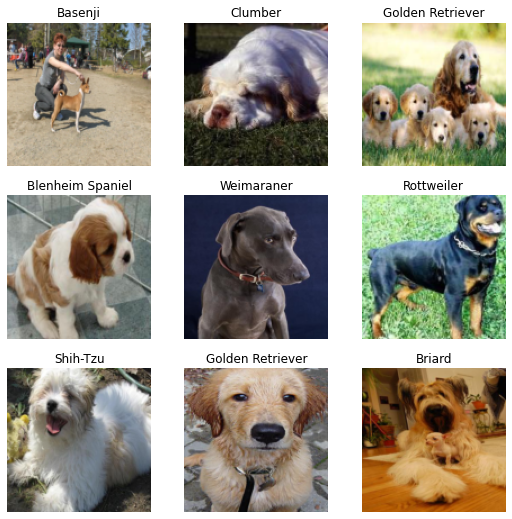

In [10]:
# show some items from validation set
dls.valid.show_batch()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


(0.006918309628963471, 0.02290867641568184)


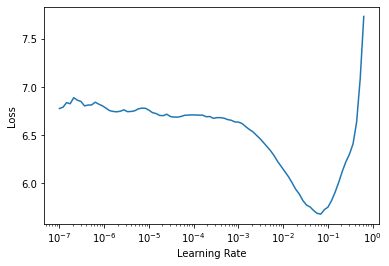

In [11]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

set_seed(SEED, dls=dls)
lr_min, lr_steep = learn.lr_find()
print((lr_min, lr_steep))

In [12]:
# 3 epochs with ResNet50 layers frozen, training new layers
# 10 additional epochs with the ResNet50 unfrozen, training all layers

set_seed(SEED)
learn.fine_tune(epochs=10, freeze_epochs=3, base_lr=lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,2.660737,1.896972,0.498056,00:54
1,2.143288,1.735716,0.519193,00:54
2,2.067469,1.618727,0.547133,00:55


epoch,train_loss,valid_loss,accuracy,time
0,1.867379,1.717511,0.520894,00:55
1,2.053064,1.996963,0.432459,00:55
2,2.207220,2.105968,0.428328,00:55
3,2.039077,1.952165,0.452138,00:55
4,1.795939,1.844396,0.496356,00:55
5,1.528771,1.586457,0.550534,00:55
6,1.281351,1.424005,0.599368,00:55
7,1.011020,1.323992,0.627065,00:55
8,0.839674,1.264746,0.652575,00:55
9,0.749364,1.269996,0.652089,00:55


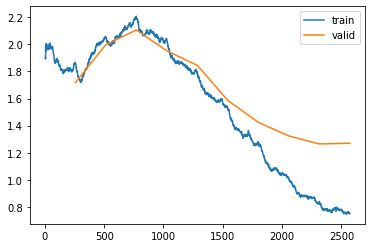

In [13]:
learn.recorder.plot_loss()

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

# Instead of showing confusion matrix (which would be 120x120, since we have 120 dog breeds),
# get counts of the breeds that were most confused for one another
interp.most_confused(min_val=5)

[('German Shepherd', 'Malinois', 13),
 ('Whippet', 'Italian Greyhound', 10),
 ('Malamute', 'Siberian Husky', 9),
 ('Miniature Schnauzer', 'Standard Schnauzer', 9),
 ('Staffordshire Bullterrier', 'American Staffordshire Terrier', 9),
 ('Appenzeller', 'Greater Swiss Mountain Dog', 8),
 ('Airedale', 'Irish Terrier', 7),
 ('Appenzeller', 'Entlebucher', 7),
 ('Collie', 'Shetland Sheepdog', 7),
 ('Entlebucher', 'Greater Swiss Mountain Dog', 7),
 ('Eskimo Dog', 'Malamute', 7),
 ('French Bulldog', 'Boston Bull', 7),
 ('Lakeland Terrier', 'Airedale', 7),
 ('Redbone', 'Bloodhound', 7),
 ('Shih-Tzu', 'Tibetan Terrier', 7),
 ('Brittany Spaniel', 'Welsh Springer Spaniel', 6),
 ('Doberman', 'Miniature Pinscher', 6),
 ('Entlebucher', 'Appenzeller', 6),
 ('Eskimo Dog', 'Siberian Husky', 6),
 ('Groenendael', 'Schipperke', 6),
 ('Lhasa', 'Tibetan Terrier', 6),
 ('Malamute', 'Norwegian Elkhound', 6),
 ('Norwich Terrier', 'Norfolk Terrier', 6),
 ('Shetland Sheepdog', 'Collie', 6),
 ('Shih-Tzu', 'Lhasa', 6

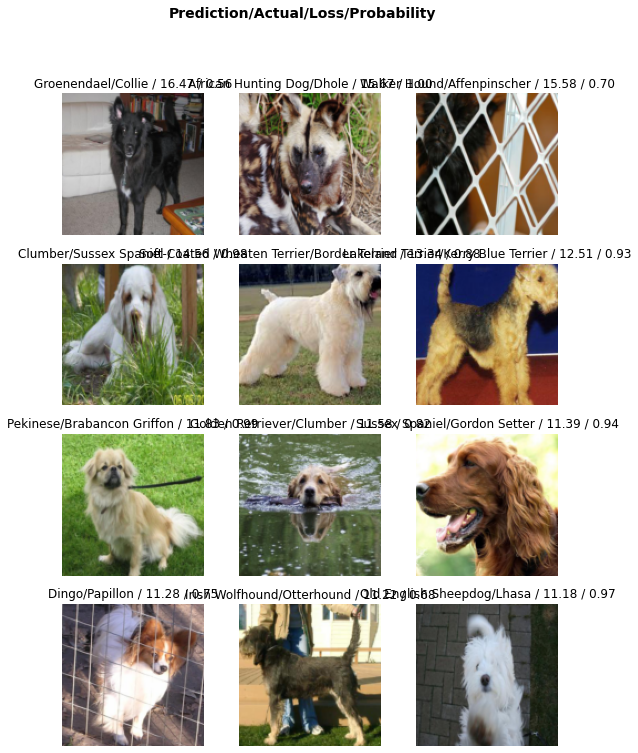

In [23]:
# show the images with the highest losses in our dataset
# titles are: (prediction, actual, loss, and probability)
interp.plot_top_losses(12, nrows=4)

In [26]:
# save our model
learn.export(os.path.join(gdrive_path, "dogs_simple_resnet18_fastai_{}.pkl".format(datetime.now().strftime("%Y%m%d_%H%M%S"))))

In [37]:
widgets

<module 'ipywidgets.widgets' from '/usr/local/lib/python3.6/dist-packages/ipywidgets/widgets/__init__.py'>

In [47]:
# the code in this cell taken from fastai book
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.HTML()
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn.predict(img)

    top5_preds = sorted(list(zip(learn.dls.vocab, list(probs.numpy()))), key=lambda x: x[1], reverse=True)[:5]
    lbl_pred.value = '<br>'.join([f'* {x[0]} ({x[1]:.04f})' for x in top5_preds])
    print(f'{pred}, confidence = {probs[pred_idx]:.04f}')
btn_run.on_click(on_click_classify)

VBox([widgets.Label('Upload an image of a dog'), 
      btn_upload, 
      btn_run, 
      out_pl, 
      lbl_pred])

Kuvasz, confidence = 0.2999


Pekinese, confidence = 0.9921


Bluetick, confidence = 0.9997


Dingo, confidence = 0.7456
